### Replicates the 3 state model case for Simulation purposes with Refactored Code

In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables for the 3 state model assuming UF/OF transition (lean)
x0sim = VariableVector(cAl2O3=2.5, uAl2O3=0.1, ACD= 2.9193)

In [8]:
# Create Input Vector Variables
u0sim = VariableVector(I=126000.0, g=0.0, B=0.0)

In [9]:
# Create Measurement Vector Variables
z0sim = VariableVector(Vcell=4.465858)

In [10]:
# Define the F matrix for 3 state model with first order dependency on dT
Fsim = ControlMatrix(3, 3, 1)
# Identity matrix for the terms independent of dT
Fsim.set_array_layer(0, np.identity(3, dtype=float))
# first order dependency on dT in layer 1
Fsim.set_array_layer(1, np.array([[0.0, bbcell.kdiss, 0.0], [0.0, -bbcell.kdiss, 0.0], [0.0, 0.0, 0.0]]))

True

In [11]:
# demonstrate the F matrix evaluated with dT = 5 sec
Fsim.array_eval(5)

array([[1.  , 0.01, 0.  ],
       [0.  , 0.99, 0.  ],
       [0.  , 0.  , 1.  ]])

In [12]:
# Define G with simple 3 terms, diagonal "dT"
Gsim = ControlMatrix(3, 3, 1)
Gsim.set_array_layer(0, np.zeros((3,3)))
Gsim.set_array_layer(1, np.identity(3, dtype=float))

True

In [13]:
# demonstrate the G matrix evaluated with dT = 5 sec
Gsim.array_eval(5)

array([[5., 0., 0.],
       [0., 5., 0.],
       [0., 0., 5.]])

In [14]:
# Define the B matrix for the 3 state, 3 input model with first order dependency on dT
Bsim = ControlMatrix(3, 3, 1)
Bsim.set_array_layer(0, np.array([[0.0, 100*(1-bbcell.r)/bbcell.m, 0.0], [0.0, 100*bbcell.r/bbcell.m, 0.0], [0.0, 0.0, 1.0]]))
Bsim.set_array_layer(1, np.array([[-gamma/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [bbcell.alpha, 0.0, 0.0]]))

True

In [15]:
# demonstrate the B matrix evaluated with dT = 5 sec
Bsim.array_eval(5)

array([[-4.62315993e-08,  2.22222222e-02,  0.00000000e+00],
       [ 0.00000000e+00,  3.33333333e-02,  0.00000000e+00],
       [-1.64690382e-10,  0.00000000e+00,  1.00000000e+00]])

In [16]:
# Define the noise standard deviations for simulation purposes (ie relatively low)
q1dstd = 0.0004    # alumina concentration variation
q1ustd = 0.0002    # undisolved alumina concentration variation
q2std = 0.0000001  # acd varation needs to be much lower
Qsim = ControlMatrix(3, 3, 0)
Qsim.set_array_layer(0, np.array([[q1dstd**2, 0.0, 0.0], [0.0, q1ustd**2, 0.0], [0.0, 0.0, q2std**2]]))
Qsim.array_display

array([[[1.6e-07, 0.0e+00, 0.0e+00],
        [0.0e+00, 4.0e-08, 0.0e+00],
        [0.0e+00, 0.0e+00, 1.0e-14]]])

In [17]:
# Define the measurement standard deviation
rstd = 0.001      # measurement variation (volts)
Rsim = ControlMatrix(1, 1, 0)
Rsim.set_array_layer(0, np.array([[rstd**2]]))
Rsim.array_display

array([[[1.e-06]]])

In [18]:
from Refactor.UKFClass import DiscreteModel

In [19]:
# Define the 3 state model object instance for simulation
alumina3state = DiscreteModel(Fsim, Bsim, Gsim, Qsim, Rsim, z0sim, u0sim, x0sim)
alumina3state.defined

True

In [20]:
# Import the UKF class and supporting functions
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack, ukf_execute, ukf_gen_samples

In [21]:
# Import the Sim class and supporting functions
from Refactor.SimClass import SimCell, plot_xsim, plot_usim, plot_zsim

In [22]:
# verify the actual shot mass for the cell
# bbcell.shotMass.value = 0.9
bbcell.shotMass.value

5.8

In [23]:
# now let us introduce a discrepancy between the shot mass set point and the actual
bbcell.shotSetPoint.value = 5.5
bbcell.calc_feed_cycle(126000)

(262.27127417862357, True)

In [24]:
# lets create an instance of the simulation class using the 3 state model
sim3state = SimCell(alumina3state, bbcell, 5, shotstd=0.01, Istd=25, statenoise=True)
sim3state.sim_valid

True

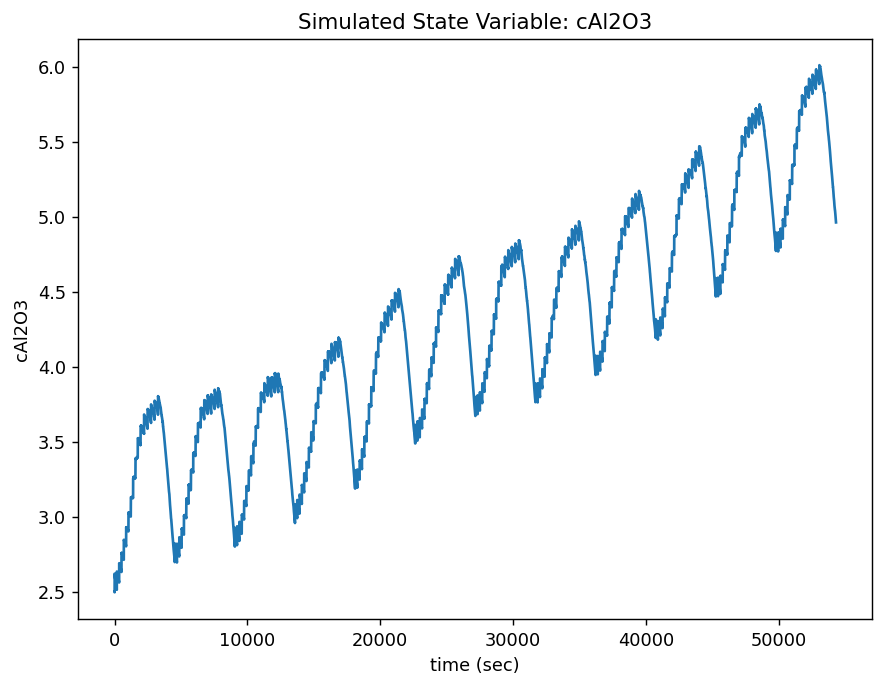

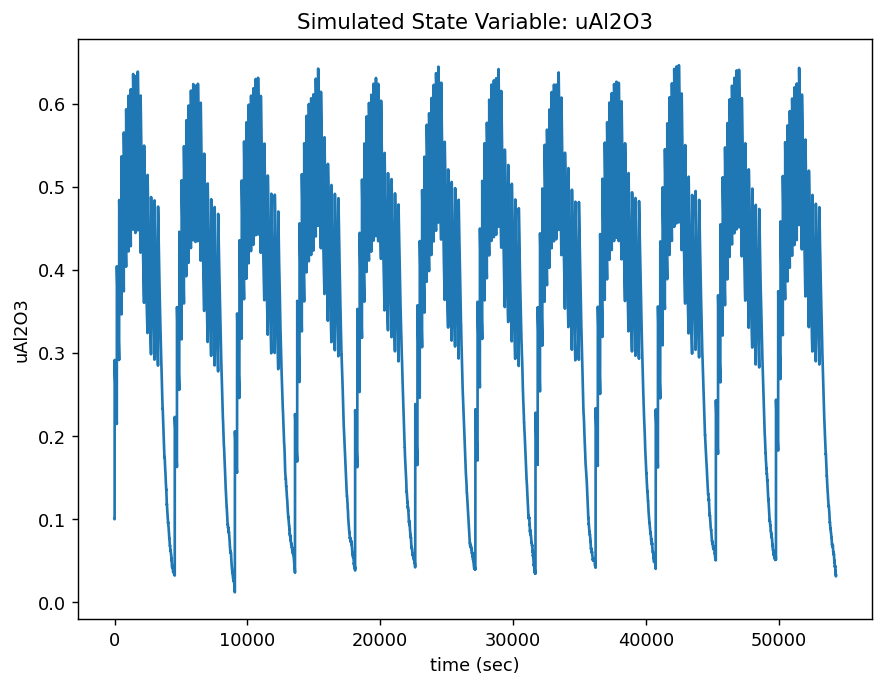

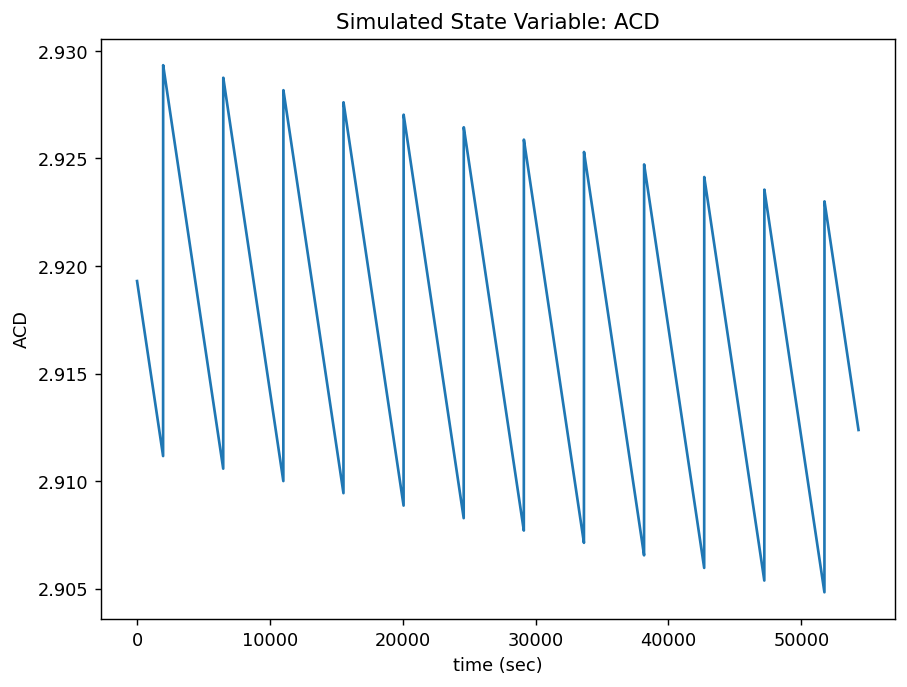

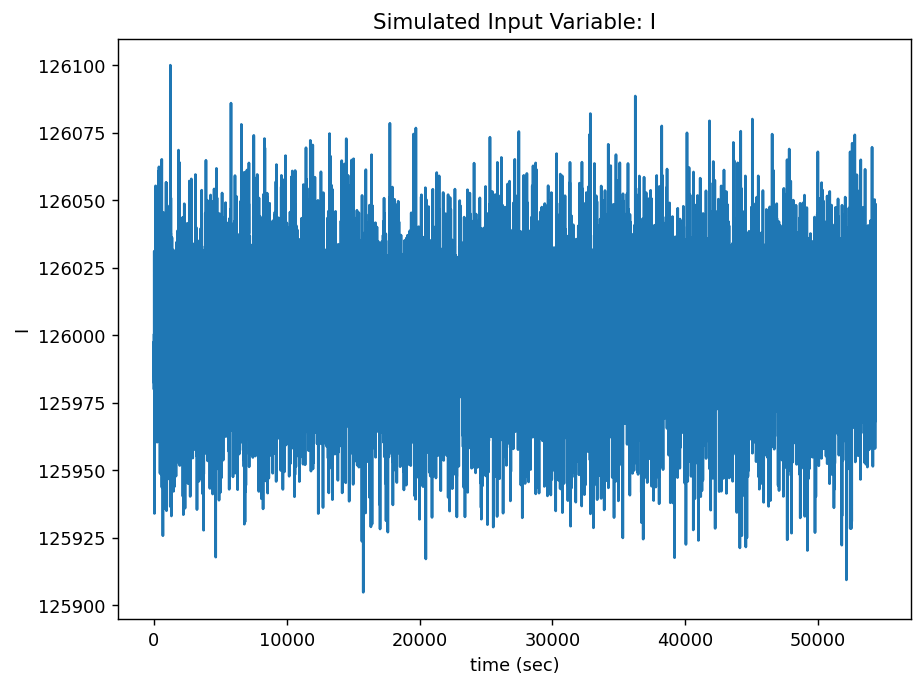

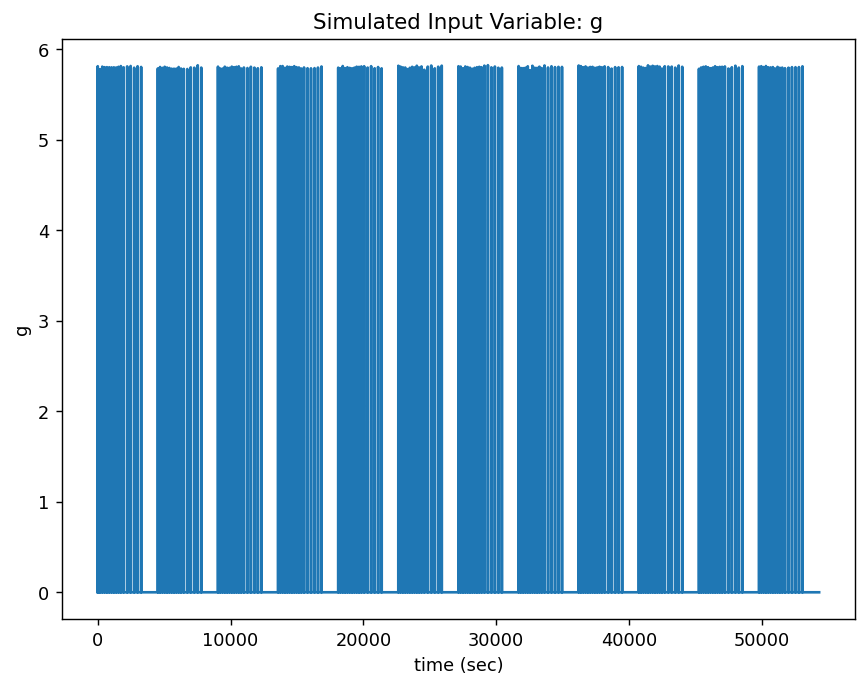

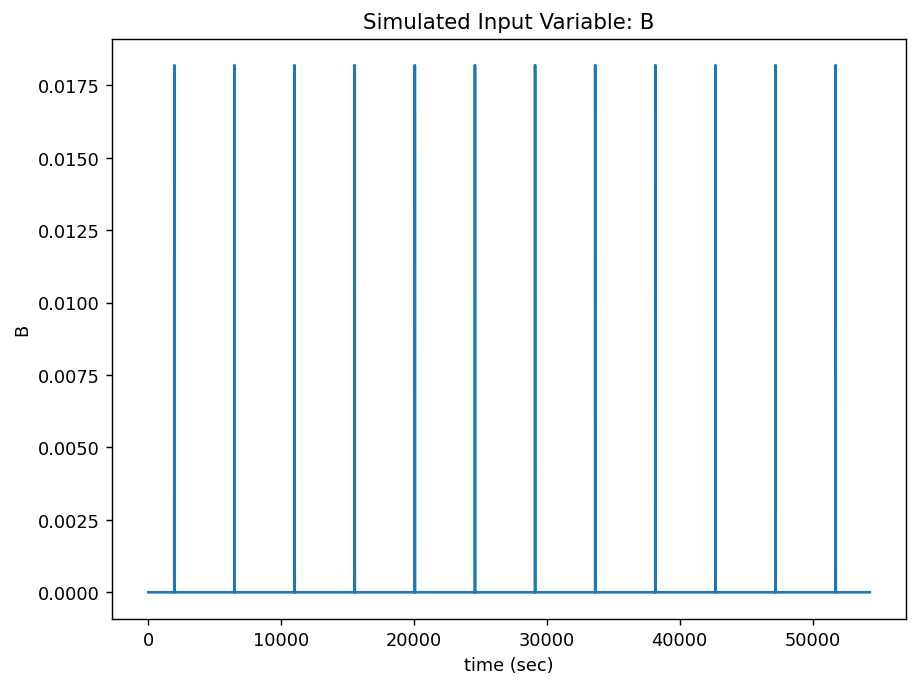

In [25]:
# Run a simulation at 5 sec dT and with 4 full adaptive feed cycles - 25kg OF, 20 min nominal and 20min UF (timed, not dependent on dR or dR/dt)
xtrue, utrue, unom = sim3state.sim_adaptfeedcycle(5, 25, 1.5, 1200, 1250, u0sim, x0sim, BeamMove=0.0182, plotresult=True, NumCycles=12)

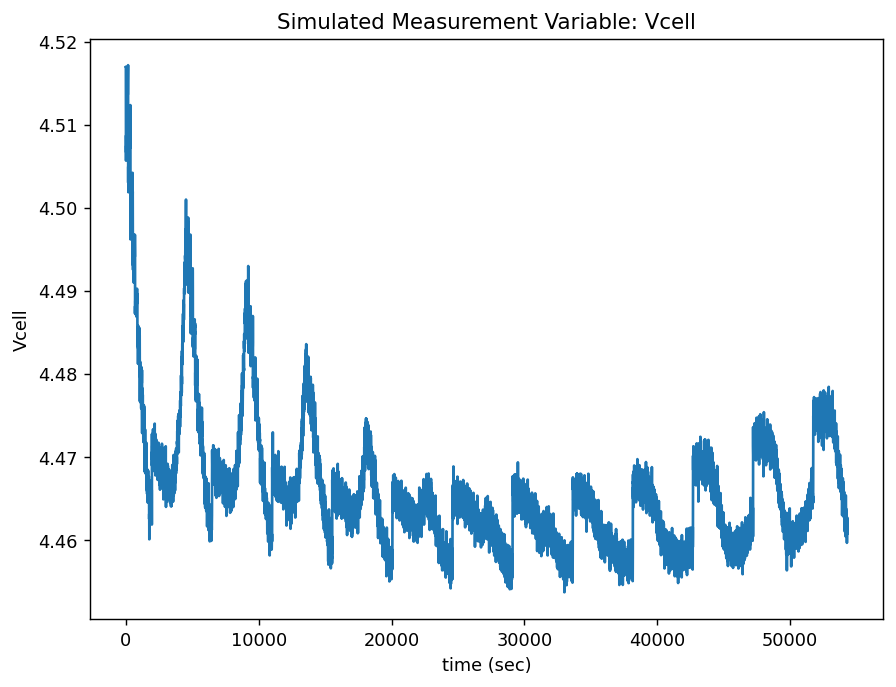

In [26]:
ztrue = sim3state.sim_observation(5, xtrue, utrue, plotresult=True)

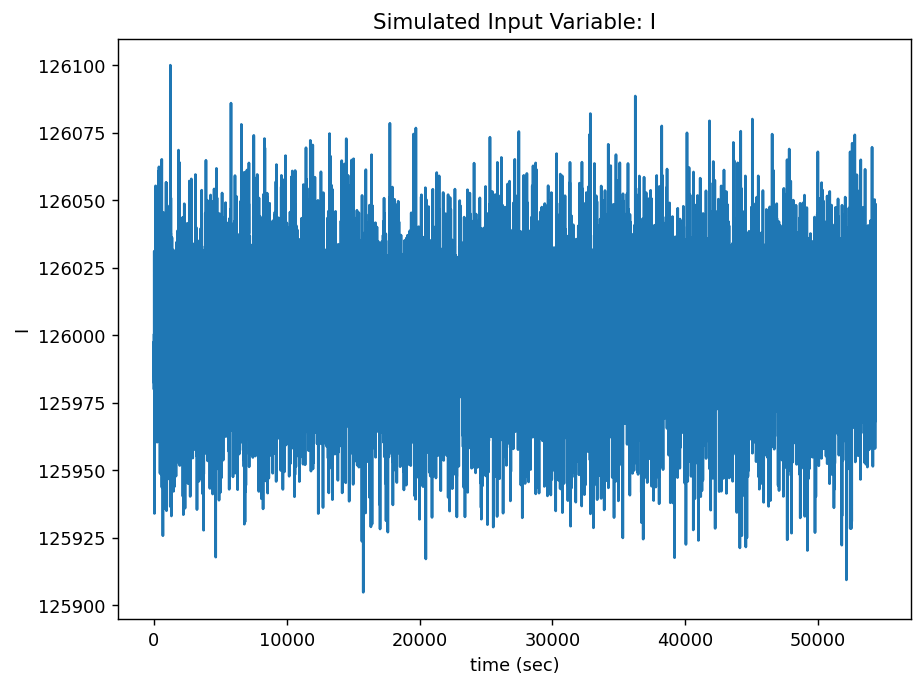

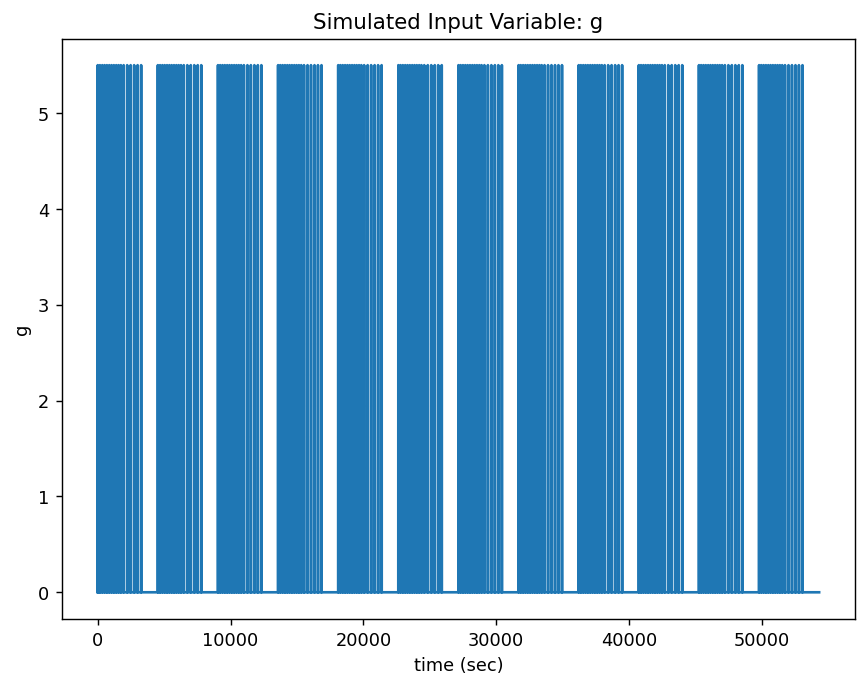

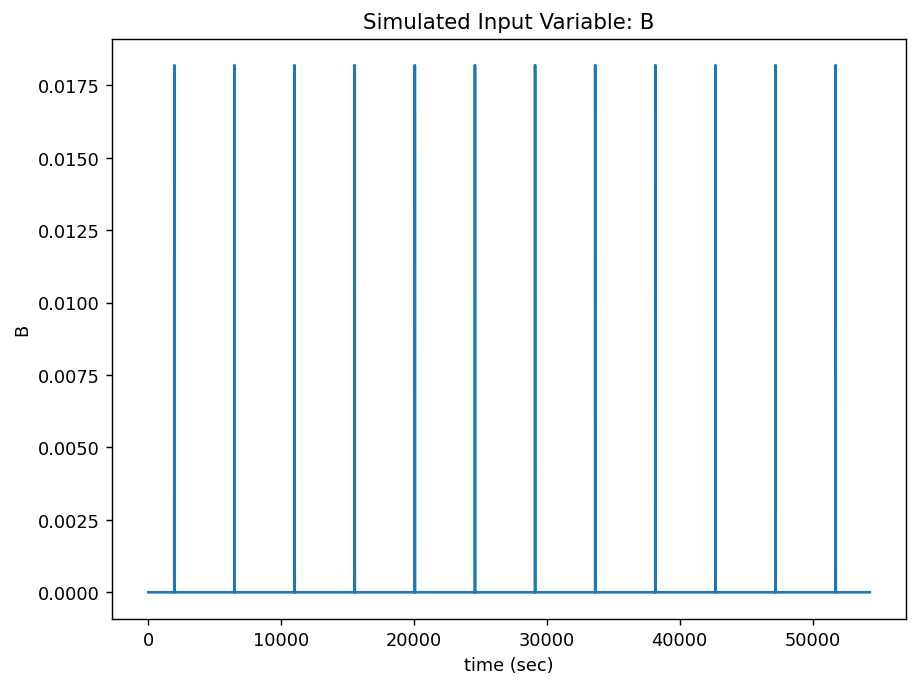

In [27]:
# plotting of the nominal feed input (not the simulated actual)
plot_usim(list(u0sim.dictionary.keys()), unom, 5)

In [28]:
# now need to repackage the simulation to suit the revised 3 state model. First lets define the revised 3-state model

In [29]:
# Create initial State, Input and Measurement Vector Variables
x0 = VariableVector(cAl2O3=2.5, deltag_rate=0.00, deltaI=0.0)
u0 = VariableVector(g0=0.0, ACD=2.9193, I0=126000.0)
z0 = VariableVector(Vcell=4.465858, Icell=126000.0)

In [30]:
# Now need to define the revised 3 state model for use in the Kalman filter
# define the time constant forthe delta g rate model
# kdeltag = bbcell.kdiss
kdeltag = 0.005

In [31]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(3, 3, 1)
# Identity matrix for the terms independent of dT
F.set_array_layer(0, np.identity(3, dtype=float))
# first order layer has a few elements dependent on dT
F.set_array_layer(1, np.array([[0.0, 100/bbcell.m, -gamma/bbcell.m],
                               [0.0, -kdeltag, 0.0],
                               [0.0, 0.0, 0.0]]))

True

In [32]:
# evaluate F with dT = 5 sec
F.array_eval(5)

array([[ 1.00000000e+00,  2.77777778e-01, -4.62315993e-08],
       [ 0.00000000e+00,  9.75000000e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [33]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(3, 3, 1)
G.set_array_layer(0, np.zeros((3,3)))
G.set_array_layer(1, np.identity(3, dtype=float))

True

In [34]:
# evaluate G with dT = 5 sec
G.array_eval(5)

array([[5., 0., 0.],
       [0., 5., 0.],
       [0., 0., 5.]])

In [35]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(3, 3, 1)
B.set_array_layer(0, np.array([[100/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]))

True

In [36]:
# evaluate B with dT = 5 sec
B.array_eval(5)

array([[ 5.55555556e-02,  0.00000000e+00, -4.62315993e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [37]:
# Define the UKF noise standard deviations - Some tuning already applied relative to R - comments show original settings
q1std = 0.01         # 0.0002 alumina concentration variation (wt%) 0.01
q2std = 0.001        # 0.0002 alumina feed mass discrepancy (kg/sec) 0.0005
q3std = 30           # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(3, 3, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0],
                               [0.0, q2std**2, 0.0],
                               [0.0, 0.0, q3std**2]]))
Q.array_display

array([[[1.e-04, 0.e+00, 0.e+00],
        [0.e+00, 1.e-06, 0.e+00],
        [0.e+00, 0.e+00, 9.e+02]]])

In [38]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 5           # 20 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))
R.array_display

array([[[1.0e-06, 0.0e+00],
        [0.0e+00, 2.5e+01]]])

In [39]:
# initialise the revised 3 state model
alumina3state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)
alumina3state.defined

True

In [40]:
# transform simualtion to the new model using the actual state and measuements but the nominal inputs
# from Refactor.Simulation import sim_transform
validtrfm, xsim, usim, zsim = sim3state.sim_transform(xtrue, unom, ztrue, 126000.0, 100, alumina3state)
validtrfm

True

In [41]:
# update the initial vector in the model to match the transformation
z0.setvector(zsim[0])
alumina3state.z0.setvector(zsim[0])
z0.vector

array([[4.5169658e+00],
       [1.2600000e+05]])

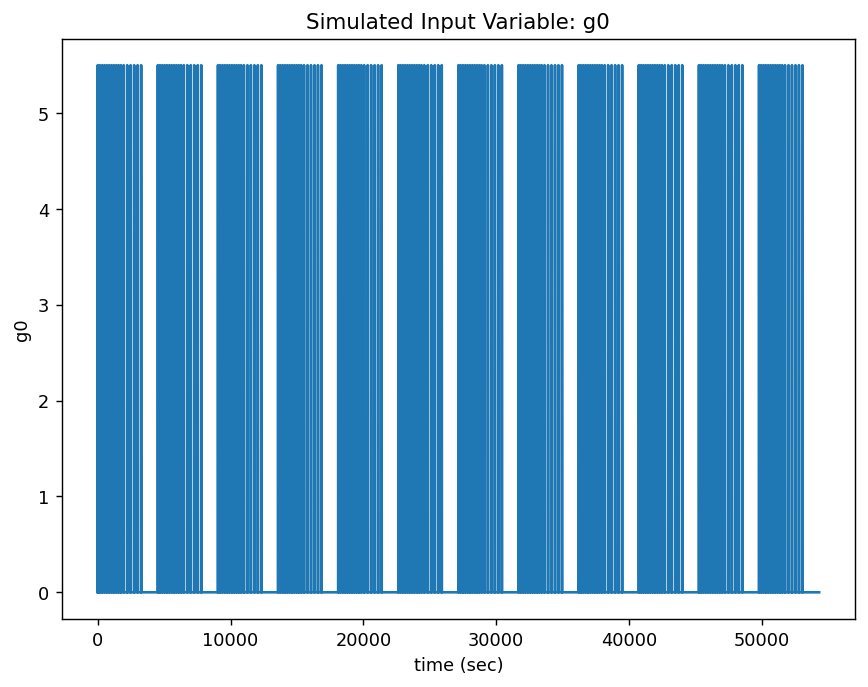

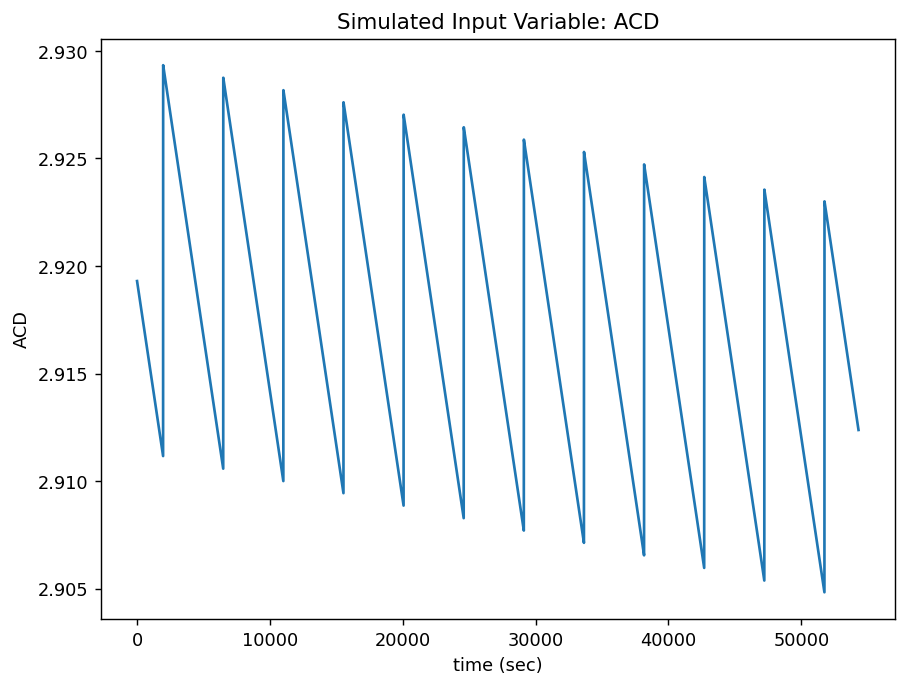

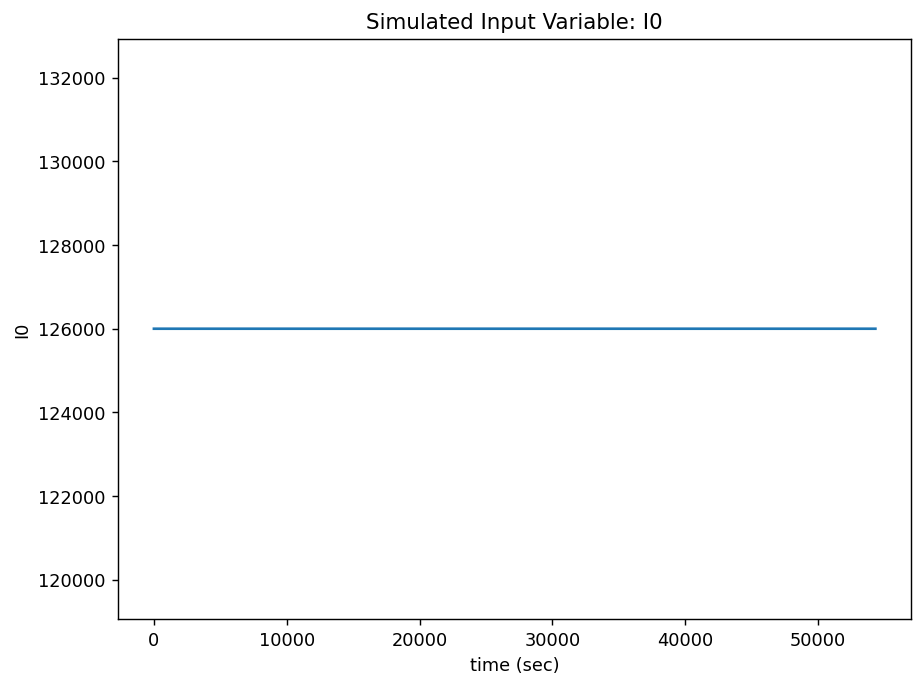

In [42]:
# plotting of the feed input as transformed - just to check all is good
plot_usim(list(u0.dictionary.keys()), usim, 5)

### The beginning of the UKF run
### Trying to get print-out on new page

In [43]:
# normalisation test
# xnorm = VariableVector(cAl2O3=1.0, deltag_rate=1.0, deltaI=1.0)
# unorm = VariableVector(g0=1.0, ACD=1.0, I0=1.0)
# znorm = VariableVector(Vcell=1.0, Icell=1.0)
xnorm = VariableVector(cAl2O3=1.0, deltag_rate=1.0, deltaI=0.001)
unorm = VariableVector(g0=1.0, ACD=10,  I0=0.001)
znorm = VariableVector(Vcell=1.0, Icell=0.001)

In [44]:
# Create an instance of the unscented Kalman Filter using the 4 state model
UKF3state = UKF(alumina3state, bbcell, x0, 5, xnorm=xnorm, unorm=unorm, znorm=znorm)
UKF3state.initialised

True

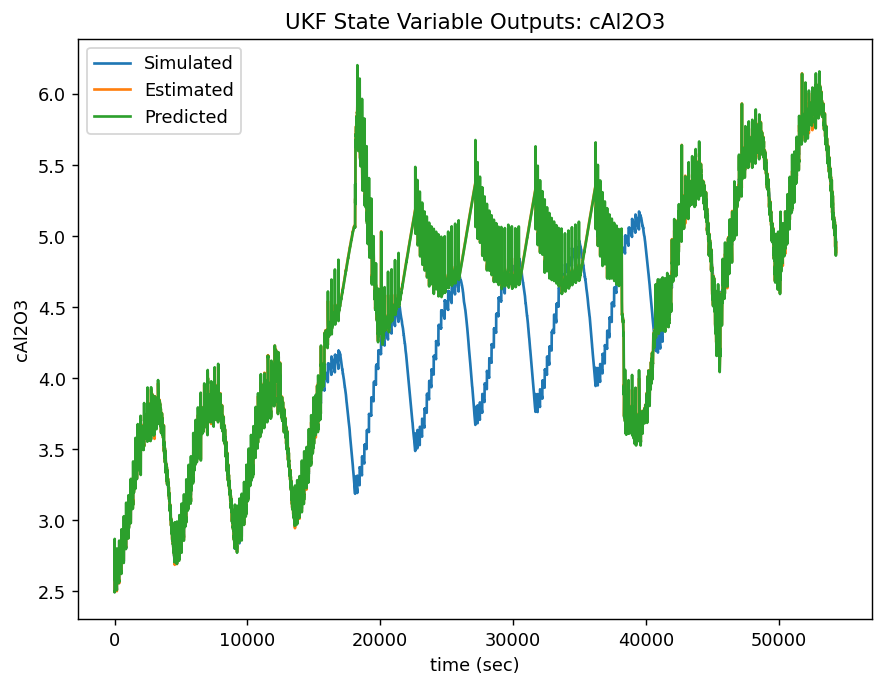

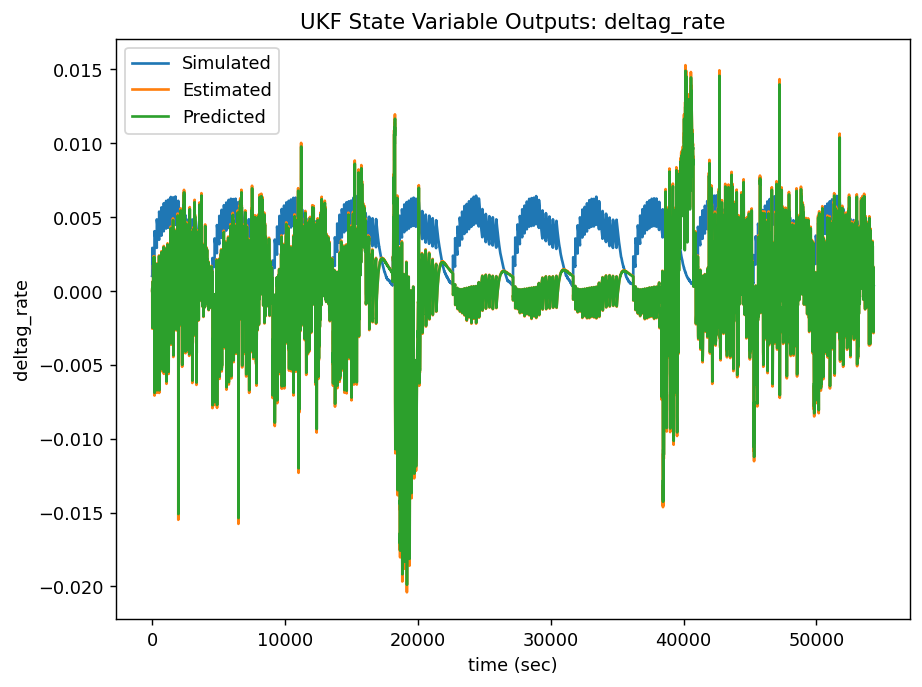

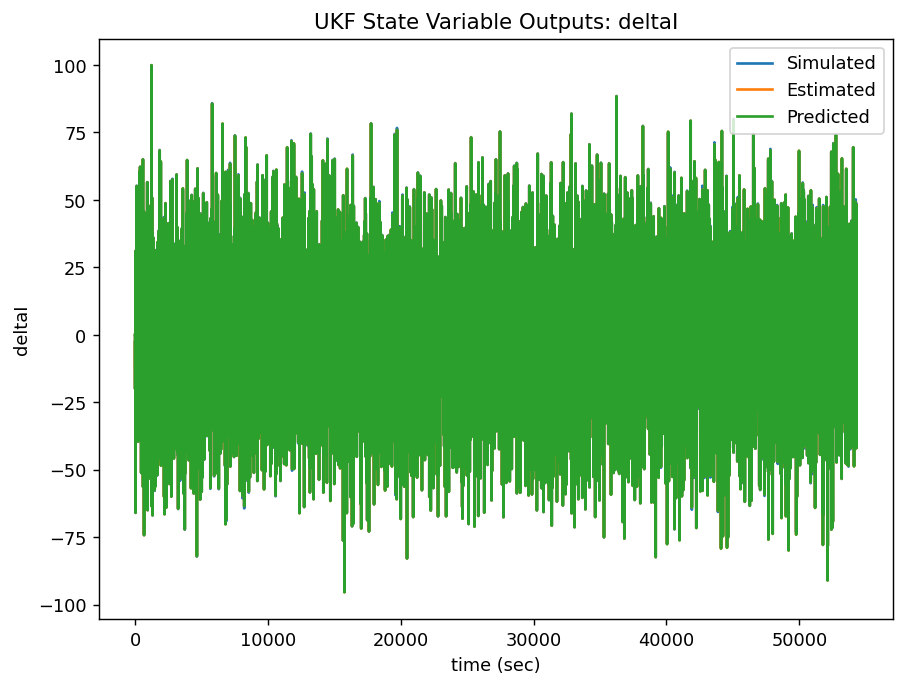

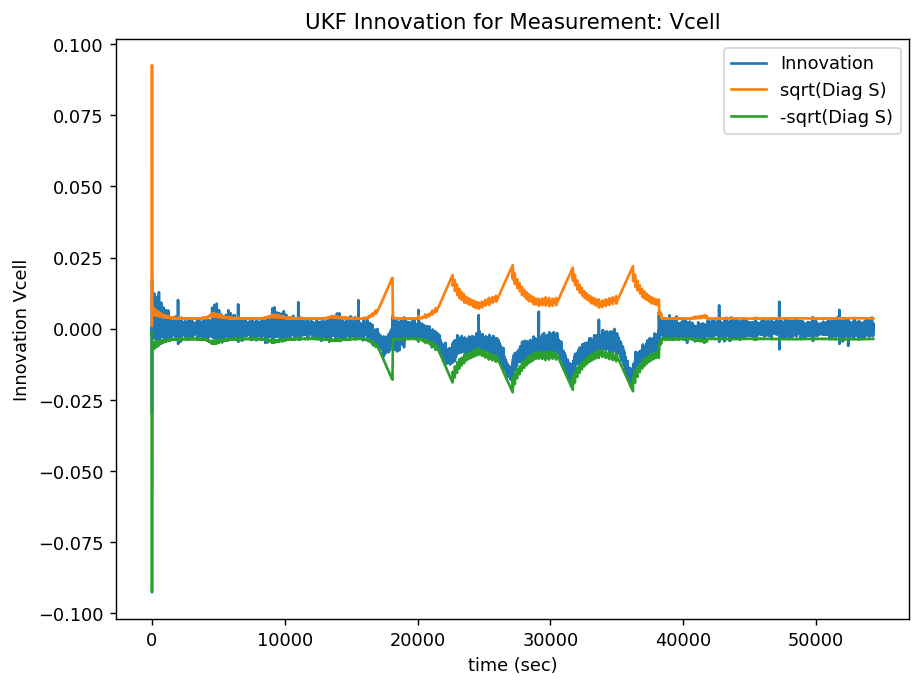

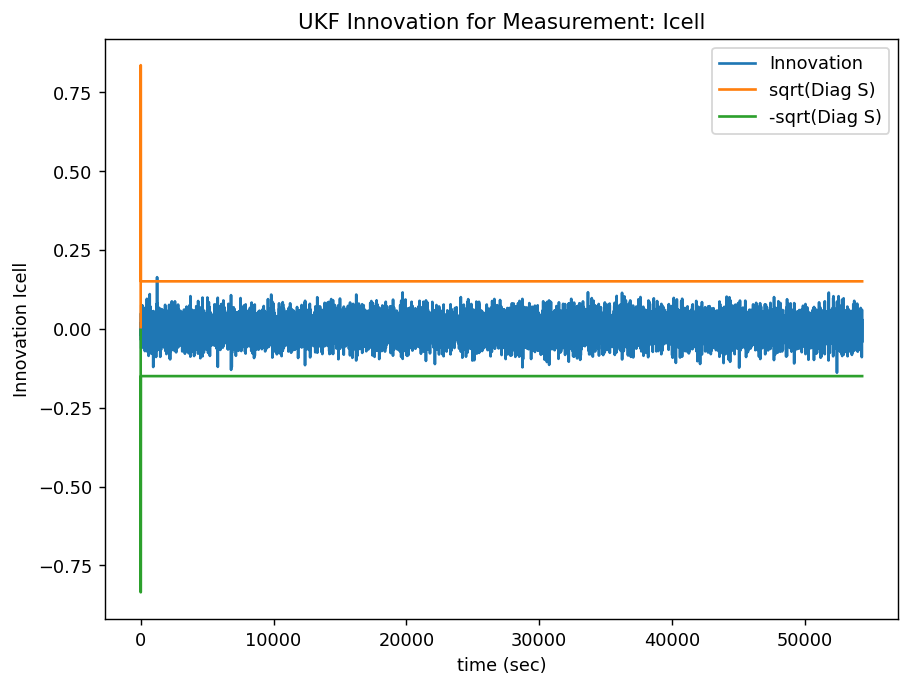

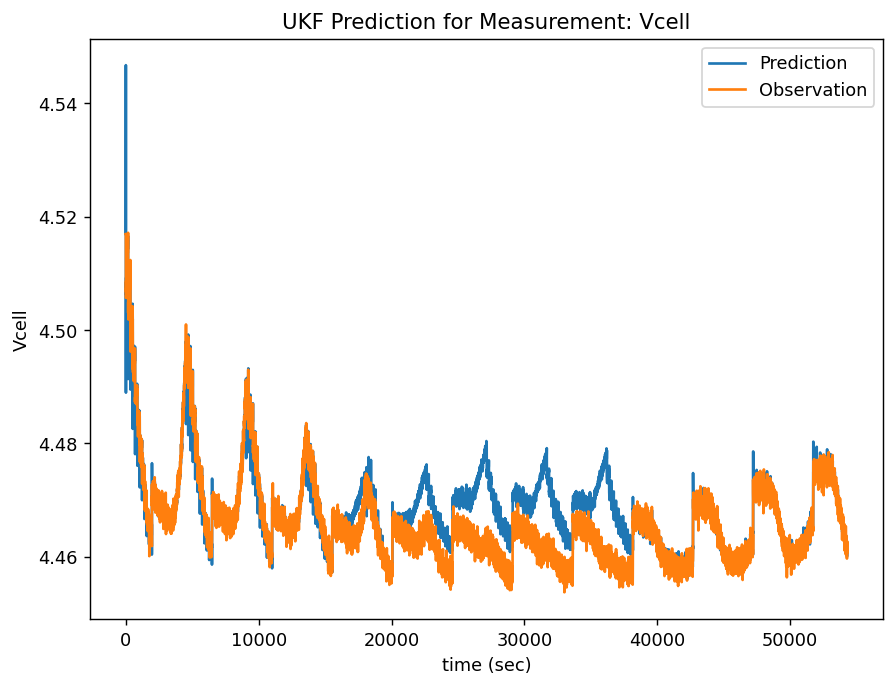

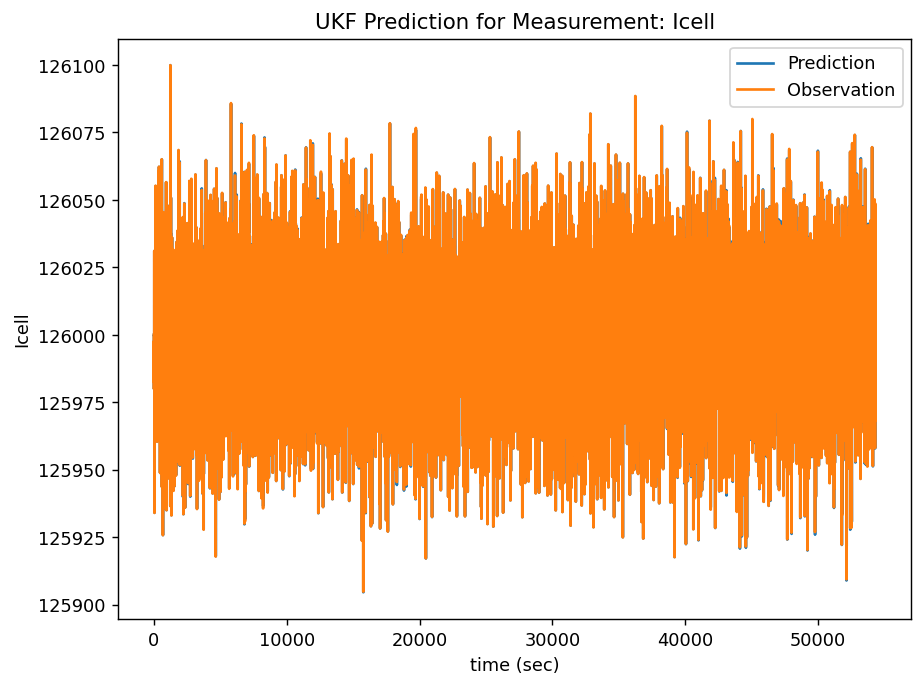

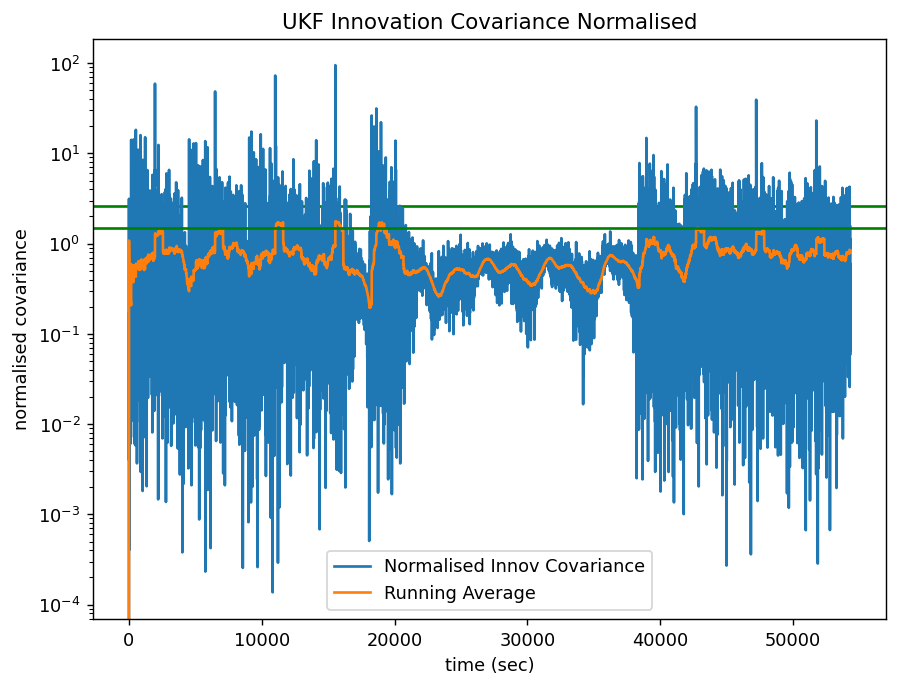

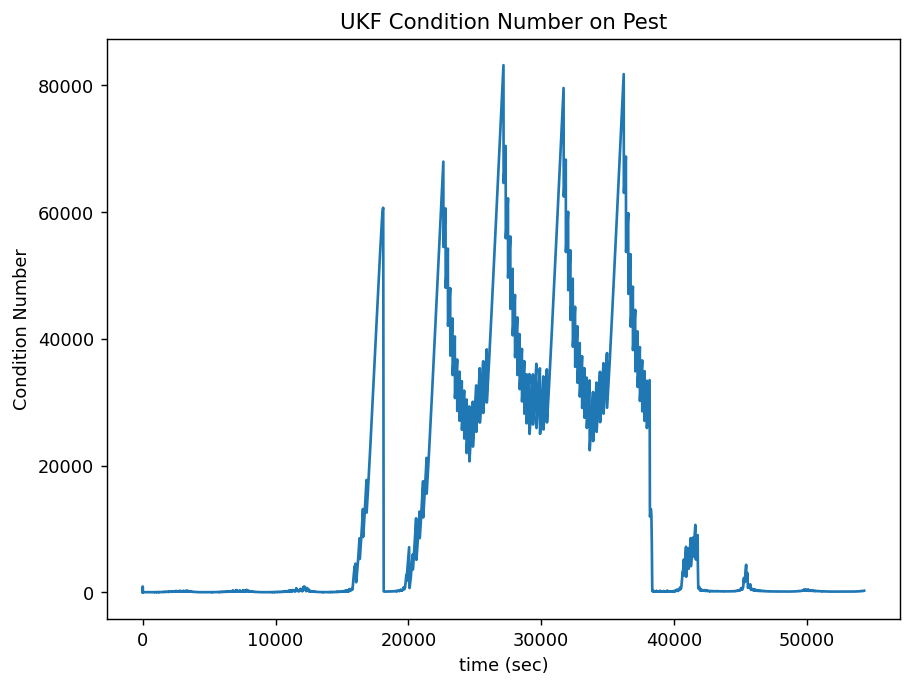

In [45]:
# Run the simulation through the UKF 3 state model 
xest, Pest, xpred, Ppred, innov, innov_cov, cond = ukf_execute(UKF3state, zsim, usim, 5, plotresult=True, xtrue=xsim)

In [46]:
for i in range(7):
    xpredlast = UKF3state.xpredsamples[i]/UKF3state.xnorm
    zpredlast = UKF3state.zpredsamples[i]/UKF3state.znorm
    print(f'xpred[{i}]:')
    print(xpredlast)
    print(f'zpred[{i}]:')
    print(zpredlast)


xpred[0]:
[[4.95458530e+00]
 [1.40812886e-03]
 [2.13945368e+01]]
zpred[0]:
[[4.46163337e+00]
 [1.26021395e+05]]
xpred[1]:
[[5.14536344e+00]
 [9.07101915e-03]
 [2.08817484e+01]]
zpred[1]:
[[4.46318748e+00]
 [1.26020882e+05]]
xpred[2]:
[[ 4.76380716e+00]
 [-6.25476144e-03]
 [ 2.19073253e+01]]
zpred[2]:
[[4.46040454e+00]
 [1.26021907e+05]]
xpred[3]:
[[ 4.9545853 ]
 [ 0.04185273]
 [21.39788462]]
zpred[3]:
[[4.46163345e+00]
 [1.26021398e+05]]
xpred[4]:
[[ 4.9545853 ]
 [-0.03903647]
 [21.391189  ]]
zpred[4]:
[[4.46163330e+00]
 [1.26021391e+05]]
xpred[5]:
[[4.95458530e+00]
 [1.40812886e-03]
 [3.21559089e+02]]
zpred[5]:
[[4.46836563e+00]
 [1.26321559e+05]]
xpred[6]:
[[ 4.95458530e+00]
 [ 1.40812886e-03]
 [-2.78770016e+02]]
zpred[6]:
[[4.45490022e+00]
 [1.25721230e+05]]


In [47]:
posdef, xsample, weight = ukf_gen_samples(UKF3state.xpred.vector, UKF3state.Ppred, UKF3state.ukf_gamma)

sigma[0]:
[[ 0.19077814]
 [ 0.00766289]
 [-0.00051279]]
sigma[1]:
[[0.00000000e+00]
 [4.04446014e-02]
 [3.34781132e-06]]
sigma[2]:
[[0.        ]
 [0.        ]
 [0.30016455]]


In [48]:
posdef, xsample, weight = ukf_gen_samples(xpred[8000],Ppred[8000], UKF3state.ukf_gamma)

sigma[0]:
[[0.1575231 ]
 [0.0065361 ]
 [0.00054453]]
sigma[1]:
[[ 0.00000000e+00]
 [ 4.04352189e-02]
 [-3.27084271e-06]]
sigma[2]:
[[0.        ]
 [0.        ]
 [0.30016477]]


In [49]:
np.shape(xpred)

(10861, 3, 1)

In [50]:
Ppred[10030]

array([[ 8.91539829e-03,  3.58063458e-04, -2.30158117e-05],
       [ 3.58063458e-04,  4.23762235e-04, -8.91097373e-07],
       [-2.30158117e-05, -8.91097373e-07,  2.25247473e-02]])

In [51]:
Ppred[10046]

array([[ 8.44441595e-03,  3.41379734e-04, -2.30771221e-05],
       [ 3.41379734e-04,  4.22990368e-04, -8.99740172e-07],
       [-2.30771221e-05, -8.99740172e-07,  2.25247540e-02]])

In [52]:
# Ppred suddenly has -ve off diagonmal terms after being positive for the previous 10045 cycles? 
Ppred[10047]

array([[ 8.54009453e-03,  3.45024080e-04, -2.37583825e-05],
       [ 3.45024080e-04,  4.23114576e-04, -9.25981775e-07],
       [-2.37583825e-05, -9.25981775e-07,  2.25247579e-02]])

In [53]:
posdef, xsample, weight = ukf_gen_samples(xpred[10046],Ppred[10046], UKF3state.ukf_gamma)

sigma[0]:
[[ 0.18378701]
 [ 0.0074299 ]
 [-0.00050226]]
sigma[1]:
[[0.00000000e+00]
 [4.04568668e-02]
 [3.28165285e-06]]
sigma[2]:
[[0.        ]
 [0.        ]
 [0.30016456]]


In [54]:
posdef, xsample, weight = ukf_gen_samples(xpred[10047],Ppred[10047], UKF3state.ukf_gamma)

sigma[0]:
[[ 0.18482526]
 [ 0.00746703]
 [-0.00051418]]
sigma[1]:
[[0.00000000e+00]
 [4.04561704e-02]
 [3.34868404e-06]]
sigma[2]:
[[0.        ]
 [0.        ]
 [0.30016457]]


In [55]:
innov[10045]

array([[-6.33364060e-06],
       [-1.81284337e-02]])

In [56]:
innov[10046]

array([[-0.00148327],
       [-0.00311758]])

In [57]:
innov[10047]

array([[-0.00034657],
       [ 0.00224836]])

In [58]:
xest[10045]

array([[4.95022237e+00],
       [2.08511955e-03],
       [8.73113055e+00]])

In [59]:
# massive increase in Xest in a single predict/estimate step...
xest[10046]

array([[ 4.88572143e+00],
       [-3.62478892e-04],
       [ 5.07559361e+00]])

In [60]:
xest[10047]

array([[ 4.86362980e+00],
       [-1.00650950e-03],
       [ 7.16234674e+00]])

In [61]:
xest[10047]

array([[ 4.86362980e+00],
       [-1.00650950e-03],
       [ 7.16234674e+00]])